In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '/kaggle/input/nasamangrove/'

In [3]:
image1988 = 'image1988.jpg'
json1988 = 'mumbai1998.json'
image2017= 'image2017.jpg'
json2017 = 'mumbai2017.json'

In [4]:
def polyextract(js):
    df= pd.read_json(path+js)
    df = df.reset_index()
    obj1 = (df[df['index']=='regions'].values[0][1][0]['shape_attributes'])
    obj2 = (df[df['index']=='regions'].values[0][1][1]['shape_attributes'])
    x1 =  obj1['all_points_x']
    y1 = obj1['all_points_y']
    x2 = obj2['all_points_x']
    y2 = obj2['all_points_y']
    x = x1 + x2 
    y = y1 + y2
    return x, y

In [5]:
def mask_image(jp,js):
    img = cv2.imread(path+jp)
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    x, y = polyextract(js)
    pts=[]
    for i in range(0,len(x)):
        pts.append([x[i],y[i]])
    cv2.drawContours(mask, [np.array([pts])], -1, (255, 255, 255), -1, cv2.LINE_AA)
    return mask, x, y

In [6]:
img1, x1, y1 = mask_image(image1988,json1988)
img2, x2, y2 = mask_image(image2017,json2017)

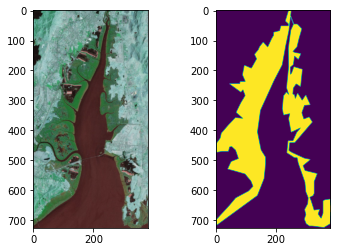

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.imread(path+image1988))
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(img1)

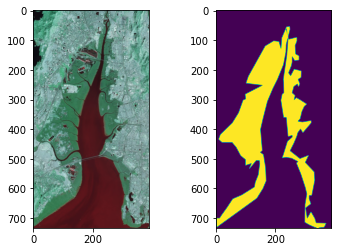

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.imread(path+image2017))
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(img2)

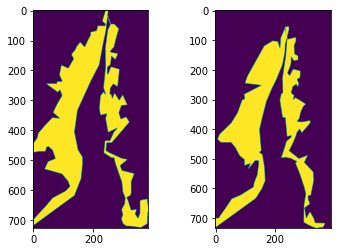

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(img2)

In [10]:
def croping_image(path,jpg):
    img = cv2.imread(path+jpg)

    pts=[]
    for i in range(0,len(x1)):
        pts.append([x1[i],y1[i]])
    pts = np.array(pts)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    
    return dst



In [11]:
croped1 = croping_image(path,image1988)
croped2 = croping_image(path,image2017)

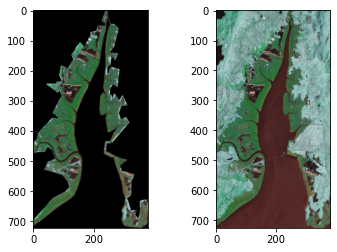

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(croped1)
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(cv2.imread(path+image1988))

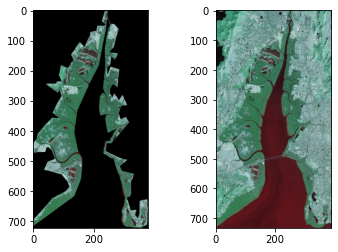

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(croped2)
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(cv2.imread(path+image2017))

In [14]:
cv2.imwrite('/kaggle/working/1998.jpg',img1)
cv2.imwrite('/kaggle/working/2017.jpg',img2)

True

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [16]:
pic = image.load_img('/kaggle/working/1998.jpg',target_size=(224, 224))
f = image.img_to_array(pic)
f = np.expand_dims(f, axis=0)
f = preprocess_input(f)
feature1 = np.array(f)

In [17]:
pic = image.load_img('/kaggle/working/2017.jpg',target_size=(224, 224))
f = image.img_to_array(pic)
f = np.expand_dims(f, axis=0)
f = preprocess_input(f)
feature2 = np.array(f)

In [18]:
model = VGG19()

574717952/574710816 [==============================] - 6s 0us/step


In [19]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [21]:
vector1 = model.predict(feature1)
vector2 = model.predict(feature2)

In [22]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))


In [23]:
findCosineDistance(vector1.flatten(),vector2.flatten())

0.5325590670108795